In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
meta = pd.read_csv('../data/retrospective_validation_results.csv')

In [3]:
meta = meta[meta['error_msg']=='No Error'].reset_index(drop=True)

In [4]:
meta.head()

,slide_id,error_msg,probability,prediction,target,CRO Site,sex,age_cat
0,831165_620782288206.svs,No Error,0.055561,1.0,0,Site #1,Male,60 to 70
1,801112.svs,No Error,0.242113,1.0,1,Site #1,Male,60 to 70
2,814500.svs,No Error,0.043455,1.0,1,Site #1,Male,<60
3,808846.svs,No Error,0.036716,1.0,0,Site #1,Male,<60
4,881160_620857856504.svs,No Error,0.006223,0.0,1,Site #1,Male,>70


Site name: Site #1
Site count: 210
Site name: Site #2
Site count: 47
Site name: Site #3
Site count: 35
Site name: Site #4
Site count: 30
Site name: Site #5
Site count: 26


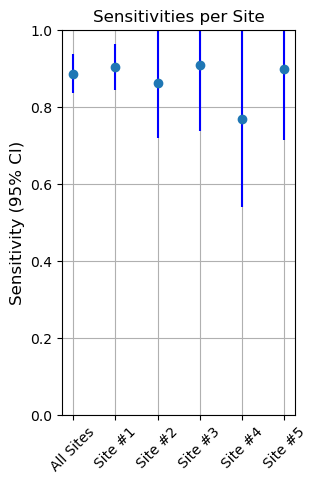

In [5]:
sites = meta['CRO Site'].value_counts().index.to_list()
sn_list = []
CI_95_h_list = []
sn = meta[(meta.prediction==1) & (meta.target==1)].shape[0]/meta[meta.target==1].shape[0]
sn_list.append(sn)
TP = meta[(meta.prediction==1) & (meta.target==1)].shape[0]
FN = meta[(meta.prediction==0) & (meta.target==1)].shape[0]
SE_sn = np.sqrt((sn*(1-sn)/(TP+FN)))
CI_95_h_list.append(1.96*SE_sn)
CI_95_h = sn + 1.96*SE_sn
CI_95_l = sn - 1.96*SE_sn
CI_95_h = min(CI_95_h, 1)

for itx, group in enumerate(sites):
    print("Site name: " + str(group))
    tmp = meta[(meta['CRO Site'] == group)].reset_index(drop=True)
    print("Site count: " + str(tmp.shape[0]))
    
    sn = tmp[(tmp.prediction==1) & (tmp.target==1)].shape[0]/tmp[tmp.target==1].shape[0]
    sn_list.append(sn)
    
    TP = tmp[(tmp.prediction==1) & (tmp.target==1)].shape[0]
    FN = tmp[(tmp.prediction==0) & (tmp.target==1)].shape[0]
    
    SE_sn = np.sqrt((sn*(1-sn)/(TP+FN)))
    CI_95_h_list.append(1.96*SE_sn)
    CI_95_h = sn + 1.96*SE_sn
    CI_95_l = sn - 1.96*SE_sn  
    CI_95_h = min(CI_95_h, 1)


fig = plt.figure(figsize=(3,5))
plt.errorbar(['All Sites', 'Site #1','Site #2','Site #3','Site #4','Site #5'], sn_list, yerr=CI_95_h_list, fmt='o', ecolor = 'blue')
plt.ylim([0,1])
plt.xticks(fontsize=10,rotation=45)

plt.ylabel('Sensitivity (95% CI)',fontsize=12)
plt.title('Sensitivities per Site',fontsize=12)
plt.grid()
plt.show()
fig.savefig('../figures/Fig4C_sensitivies.png')

In [6]:
def auROC(quantile_df, cohort):
    
    fpr_qaunt, tpr_quant, thresholds_quant = roc_curve(y_true=quantile_df['label'], y_score=quantile_df['score'], drop_intermediate=False)
    auc_plot_quant = roc_auc_score(y_true=quantile_df['label'], y_score=quantile_df['score'])
    
    if cohort=='ALL':
        plt.plot(fpr_qaunt, tpr_quant, label='ROC', linewidth=2, linestyle='-')
    else:
        plt.plot(fpr_qaunt, tpr_quant, label='ROC', linewidth=1, linestyle='-')
    
    plt.xlabel('FPR',fontsize=12)
    plt.ylabel('TPR',fontsize=12)
    print('Max AUC :', np.round(auc_plot_quant,4))
    plt.title('ROC curves per CRO Site')
    return auc_plot_quant

Max AUC : 0.7501
Site name: Site #1
Group count: 210
Max AUC : 0.7239
Site name: Site #2
Group count: 47
Max AUC : 0.8109
Site name: Site #3
Group count: 35
Max AUC : 0.8561
Site name: Site #4
Group count: 30
Max AUC : 0.7557
Site name: Site #5
Group count: 26
Max AUC : 0.65


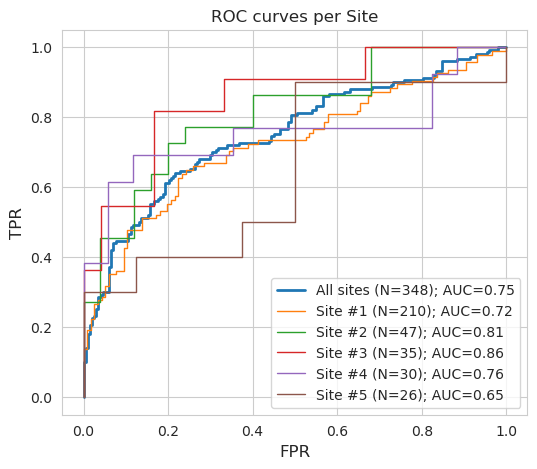

In [7]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(6,5))
auc_list = []
site_count = meta['CRO Site'].value_counts().values

meta['score']=meta['probability']
meta['label']=meta['target']
auc_list.append(auROC(meta,'ALL'))

for itx, group in enumerate(sites):
    print("Site name: " + str(group))
    tmp = meta[(meta['CRO Site'] == group)].reset_index(drop=True)
    
    print("Group count: " + str(tmp.shape[0]))
    
    tmp['score']=tmp['probability']
    tmp['label']=tmp['target']
    auc_list.append(auROC(tmp,group))
    
plt.legend(['All sites (N=' + str(site_count.sum()) + '); AUC=' + str(round(auc_list[0],2)) ,
            'Site #1 (N=' + str(site_count[0]) + '); AUC=' + str(round(auc_list[1],2)),
            'Site #2 (N=' + str(site_count[1]) + '); AUC=' + str(round(auc_list[2],2)),
            'Site #3 (N=' + str(site_count[2]) + '); AUC=' + str(round(auc_list[3],2)),
            'Site #4 (N=' + str(site_count[3]) + '); AUC=' + str(round(auc_list[4],2)),
            'Site #5 (N=' + str(site_count[4]) + '); AUC=' + str(round(auc_list[5],2))], loc=4, prop={'size': 10})
plt.title('ROC curves per Site')
fig.savefig('../figures/Fig4C_roc.png')

In [8]:
def calculate_statistics(meta):

    sn = meta[(meta.prediction==1) & (meta.target==1)].shape[0]/meta[meta.target==1].shape[0]
    sp = meta[(meta.prediction==0) & (meta.target==0)].shape[0]/meta[meta.target==0].shape[0]

    TP = meta[(meta.prediction==1) & (meta.target==1)].shape[0]
    TN = meta[(meta.prediction==0) & (meta.target==0)].shape[0]
    FP = meta[(meta.prediction==1) & (meta.target==0)].shape[0]
    FN = meta[(meta.prediction==0) & (meta.target==1)].shape[0]
    
    SE_sn = np.sqrt((sn*(1-sn)/(TP+FN)))
    SE_sp = np.sqrt((sp*(1-sp)/(FP+TN)))

    CI_95_h = sn + 1.96*SE_sn
    CI_95_l = sn - 1.96*SE_sn
    print('Sensitivitiy: ' + str(round(sn,3)) + '; 95%CI=[' + str(round(CI_95_h,3)) + ', ' + str(round(CI_95_l,3)) + ']')
    
    CI_95_h = sp + 1.96*SE_sp
    CI_95_l = sp - 1.96*SE_sp
    print('Specificity: ' + str(round(sp,3)) + '; 95%CI=[' + str(round(CI_95_h,3)) + ', ' + str(round(CI_95_l,3)) + ']')
    
    red = meta[meta.prediction==0].shape[0]/meta.shape[0]*100
    print('Reduction: ' + str(round(red)) + '% - Spec: ' + str(round(sp*100)) + '% - Sens: ' + str(round(sn*100)) + '%')

In [9]:
calculate_statistics(meta)

Sensitivitiy: 0.887; 95%CI=[0.937, 0.836]
Specificity: 0.318; 95%CI=[0.383, 0.253]
Reduction: 23% - Spec: 32% - Sens: 89%


Max AUC : 0.7501
Site name: Male
Group count: 274
Max AUC : 0.7563
Site name: Female
Group count: 74
Max AUC : 0.7276


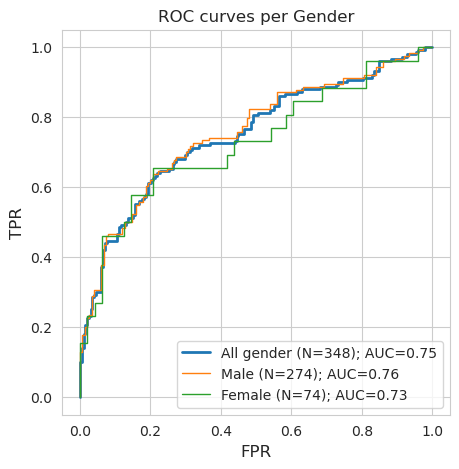

In [10]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(5,5))
auc_list = []
sex_count = meta['sex'].value_counts().values
sex_list=['Male','Female']

meta['score']=meta['probability']
meta['label']=meta['target']
auc_list.append(auROC(meta,'ALL'))

for itx, group in enumerate(sex_list):
    print("Site name: " + str(group))
    tmp = meta[(meta['sex'] == group)].reset_index(drop=True)
    
    print("Group count: " + str(tmp.shape[0]))
    
    tmp['score']=tmp['probability']
    tmp['label']=tmp['target']
    auc_list.append(auROC(tmp,group))

plt.legend(['All gender (N=' + str(site_count.sum()) + '); AUC=' + str(round(auc_list[0],2)) ,
            'Male (N=' + str(sex_count[0]) + '); AUC=' + str(round(auc_list[1],2)),
            'Female (N=' + str(sex_count[1]) + '); AUC=' + str(round(auc_list[2],2))], loc=4, prop={'size': 10})

plt.title('ROC curves per Gender')
fig.savefig('../figures/Suppl_Fig3_roc_gender.png')

Max AUC : 0.7501
Age group: <60
Group count: 80
Max AUC : 0.7309
Age group: 60 to 70
Group count: 145
Max AUC : 0.763
Age group: >70
Group count: 123
Max AUC : 0.7534


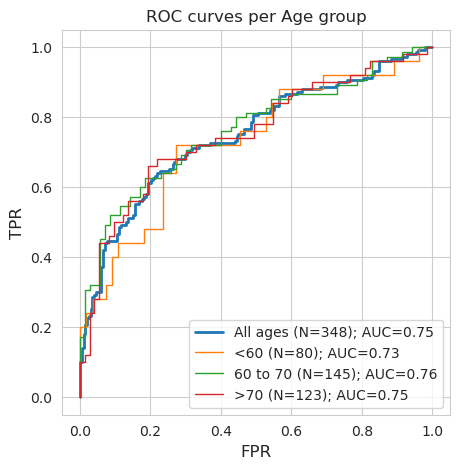

In [11]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(5,5))
auc_list = []
age_list=['<60','60 to 70', '>70']
age_count = []
meta['score']=meta['probability']
meta['label']=meta['target']
auc_list.append(auROC(meta,'ALL'))

for itx, group in enumerate(age_list):
    print("Age group: " + str(group))
    tmp = meta[(meta['age_cat'] == group)].reset_index(drop=True)
    age_count.append(tmp.shape[0])
    print("Group count: " + str(tmp.shape[0]))
    
    tmp['score']=tmp['probability']
    tmp['label']=tmp['target']
    auc_list.append(auROC(tmp,group))

plt.legend(['All ages (N=' + str(sum(age_count)) + '); AUC=' + str(round(auc_list[0],2)) ,
            '<60 (N=' + str(age_count[0]) + '); AUC=' + str(round(auc_list[1],2)),
            '60 to 70 (N=' + str(age_count[1]) + '); AUC=' + str(round(auc_list[2],2)),
            '>70 (N=' + str(age_count[2]) + '); AUC=' + str(round(auc_list[3],2))], loc=4, prop={'size': 10})

plt.title('ROC curves per Age group')
fig.savefig('../figures/Suppl_Fig3_roc_age.png')

In [12]:
def auPR(quantile_df,cohort):
    
    pr_quant, r_quant, thresholds_quant = precision_recall_curve(quantile_df['label'], quantile_df['score'])
    auPR = auc(r_quant,pr_quant)
    
    if cohort=='ALL':
        plt.plot(r_quant, pr_quant, label='auPR', linewidth=2, linestyle='-')
    else:
        plt.plot(r_quant, pr_quant, label='auPR', linewidth=1, linestyle='-')
        
    plt.xlabel('Recall',fontsize=12)
    plt.ylabel('Precision',fontsize=12)
    print('auPR:', np.round(auPR,4))
    plt.title('PR curves per CRO Site')
    return auPR

auPR: 0.7325
Male
Site name: Male
Group count: 274
auPR: 0.7533
Female
Site name: Female
Group count: 74
auPR: 0.6608


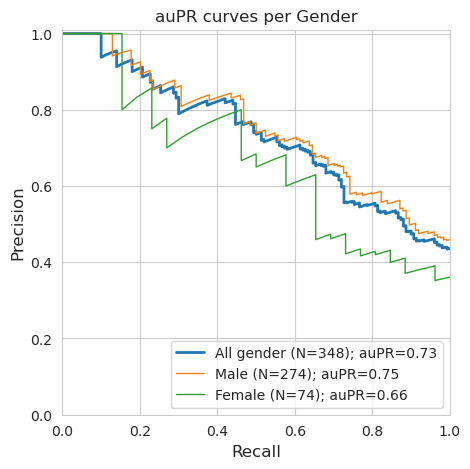

In [13]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(5,5))
auc_list = []
sex_count = meta['sex'].value_counts().values
sex_list=['Male','Female']

meta['score']=meta['probability']
meta['label']=meta['target']
auc_list.append(auPR(meta,'ALL'))

for itx, group in enumerate(sex_list):
    print(group)
    print("Site name: " + str(group))
    tmp = meta[(meta['sex'] == group)].reset_index(drop=True)
    
    print("Group count: " + str(tmp.shape[0]))
    
    tmp['score']=tmp['probability']
    tmp['label']=tmp['target']
    auc_list.append(auPR(tmp,group))

plt.ylim([0,1.01])
plt.xlim([0,1])
plt.legend(['All gender (N=' + str(site_count.sum()) + '); auPR=' + str(round(auc_list[0],2)) ,
            'Male (N=' + str(sex_count[0]) + '); auPR=' + str(round(auc_list[1],2)),
            'Female (N=' + str(sex_count[1]) + '); auPR=' + str(round(auc_list[2],2))], loc=4, prop={'size': 10})

plt.title('auPR curves per Gender')
fig.savefig('../figures/Suppl_Fig3_aupr_gender.png')

auPR: 0.7325
Age group: <60
Group count: 80
auPR: 0.6201
Age group: 60 to 70
Group count: 145
auPR: 0.8074
Age group: >70
Group count: 123
auPR: 0.7095


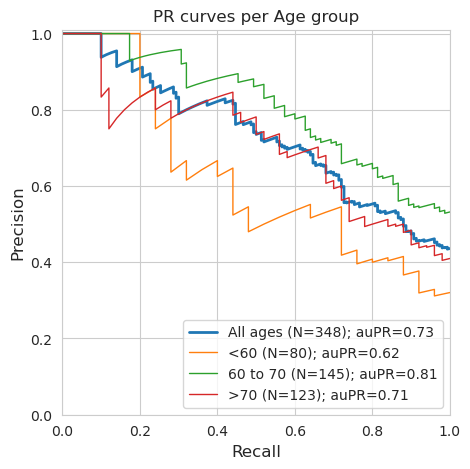

In [14]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(5,5))
auc_list = []
age_list=['<60','60 to 70', '>70']
age_count = []
meta['score']=meta['probability']
meta['label']=meta['target']
auc_list.append(auPR(meta,'ALL'))

for itx, group in enumerate(age_list):
    print("Age group: " + str(group))
    tmp = meta[(meta['age_cat'] == group)].reset_index(drop=True)
    age_count.append(tmp.shape[0])
    print("Group count: " + str(tmp.shape[0]))
    
    tmp['score']=tmp['probability']
    tmp['label']=tmp['target']
    auc_list.append(auPR(tmp,'group'))

plt.ylim([0,1.01])
plt.xlim([0,1])

plt.legend(['All ages (N=' + str(sum(age_count)) + '); auPR=' + str(round(auc_list[0],2)) ,
            '<60 (N=' + str(age_count[0]) + '); auPR=' + str(round(auc_list[1],2)),
            '60 to 70 (N=' + str(age_count[1]) + '); auPR=' + str(round(auc_list[2],2)),
            '>70 (N=' + str(age_count[2]) + '); auPR=' + str(round(auc_list[3],2))], loc=4, prop={'size': 10})

plt.title('PR curves per Age group')
fig.savefig('../figures/Suppl_Fig3_aupr_age.png')

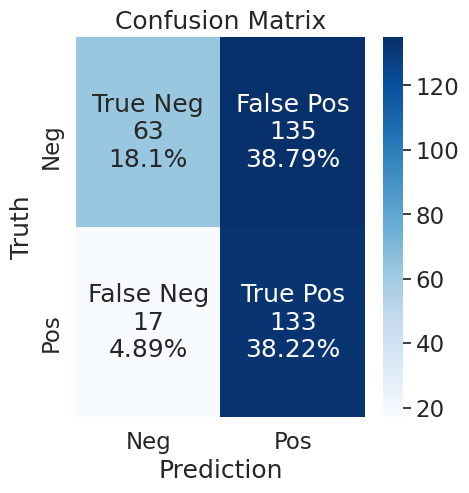

In [24]:
sns.set_style("whitegrid")
cf_matrix_quant = confusion_matrix(y_true=meta['label'], y_pred=meta['prediction'])
sns.set(font_scale=1.5)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = [f'{round(value)}' for value in cf_matrix_quant.flatten()]
group_percentages = [f'{round(value*100,2)}%' for value in cf_matrix_quant.flatten()/np.sum(cf_matrix_quant)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
fig = plt.figure(figsize=(5,5))
ax = sns.heatmap(cf_matrix_quant, annot=labels, fmt='', cmap='Blues')
ax.set(xlabel = 'Prediction', ylabel='Truth')
ax.set_xticklabels(['Neg', 'Pos'])
ax.set_yticklabels(['Neg', 'Pos'])
plt.tight_layout()
plt.title('Confusion Matrix')
fig.savefig('../figures/Fig4A.png')